In [ ]:
# interpretability/visualizer.py
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Union
import torch
import pandas as pd
import json
# Core module for handling latent concept learning and demonstration selection
from dataclasses import dataclass
import torch
import torch.nn as nn
from typing import List, Dict, Optional, Tuple, Union
from transformers import AutoModelForCausalLM, AutoTokenizer

class ConceptTokenVisualizer:
    """
    Visualizes learned concept tokens and their relationships
    Maps to Figure 5 in the paper
    """
    def __init__(self, concept_learner):
        self.concept_learner = concept_learner
        self.tsne = TSNE(n_components=2, random_state=42)
        
    def plot_concept_embeddings(self, tasks: List[str], save_path: Optional[str] = None):
        """
        Create t-SNE visualization of concept token embeddings
        Similar to Figure 5 in the paper
        """
        # Get embeddings for all concept tokens
        embeddings = []
        labels = []
        
        # Extract concept token embeddings
        embedding_matrix = self.concept_learner.model.get_input_embeddings().weight
        
        for task in tasks:
            token_ids = self._get_concept_token_ids(task)
            task_embeddings = embedding_matrix[token_ids].detach().cpu().numpy()
            embeddings.append(task_embeddings)
            labels.extend([task] * len(token_ids))
            
        embeddings = np.vstack(embeddings)
        
        # Compute t-SNE
        tsne_result = self.tsne.fit_transform(embeddings)
        
        # Plot
        plt.figure(figsize=(10, 10))
        sns.scatterplot(
            x=tsne_result[:, 0], 
            y=tsne_result[:, 1],
            hue=labels,
            style=labels,
            s=100
        )
        plt.title("t-SNE Visualization of Concept Token Embeddings")
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

    def find_similar_tokens(self, task: str, top_k: int = 10) -> List[Dict]:
        """
        Find most similar vocabulary tokens to concept tokens
        Maps to Table 13 in the paper
        """
        concept_embeds = self._get_concept_embeddings(task)
        vocab_embeds = self.concept_learner.model.get_input_embeddings().weight
        
        # Compute cosine similarity
        similarities = torch.nn.functional.cosine_similarity(
            concept_embeds.unsqueeze(1),
            vocab_embeds.unsqueeze(0),
            dim=2
        )
        
        # Get top-k similar tokens for each concept token
        top_k_values, top_k_indices = torch.topk(similarities, k=top_k, dim=1)
        
        results = []
        for i, (values, indices) in enumerate(zip(top_k_values, top_k_indices)):
            similar_tokens = [
                self.concept_learner.tokenizer.decode(idx.item())
                for idx in indices
            ]
            results.append({
                'concept_token': f"{task}_token_{i}",
                'similar_tokens': similar_tokens,
                'similarities': values.tolist()
            })
            
        return results

class DemonstrationAnalyzer:
    """
    Analyzes selected demonstrations and their properties
    """
    def __init__(self, demonstration_selector):
        self.selector = demonstration_selector
        
    def plot_score_distribution(self, candidates: List[Dict], task: str):
        """
        Plot histogram of concept token prediction scores
        Maps to Figure 10 in the paper
        """
        scores = []
        for candidate in candidates:
            if candidate['task'] == task:
                score = self.selector._compute_concept_score(candidate)
                scores.append(score)
                
        plt.figure(figsize=(10, 6))
        plt.hist(scores, bins=30)
        plt.title(f"Distribution of Concept Scores for {task}")
        plt.xlabel("Score")
        plt.ylabel("Count")
        plt.show()
        
    def analyze_demonstration_diversity(self, demonstrations: List[Dict]):
        """
        Analyze diversity of selected demonstrations
        """
        # Compute embeddings for demonstrations
        embeddings = self._get_demonstration_embeddings(demonstrations)
        
        # Compute pairwise cosine similarities
        similarities = torch.nn.functional.cosine_similarity(
            embeddings.unsqueeze(1),
            embeddings.unsqueeze(0)
        )
        
        return {
            'mean_similarity': similarities.mean().item(),
            'min_similarity': similarities.min().item(),
            'max_similarity': similarities.max().item()
        }

class PerformanceAnalyzer:
    """
    Analyzes model performance and ablation studies
    """
    def __init__(self):
        self.metrics = defaultdict(list)
        
    def log_experiment(
        self,
        experiment_name: str,
        accuracy: float,
        parameters: Dict
    ):
        """Log experimental results"""
        self.metrics[experiment_name].append({
            'accuracy': accuracy,
            'parameters': parameters
        })
        
    def plot_ablation_study(
        self, 
        parameter: str,
        experiments: List[str]
    ):
        """
        Create ablation study plots
        Maps to Figure 4 in the paper
        """
        data = []
        for exp in experiments:
            for result in self.metrics[exp]:
                data.append({
                    'parameter_value': result['parameters'][parameter],
                    'accuracy': result['accuracy'],
                    'experiment': exp
                })
                
        df = pd.DataFrame(data)
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df, 
            x='parameter_value',
            y='accuracy',
            hue='experiment'
        )
        plt.title(f"Ablation Study: Effect of {parameter}")
        plt.show()
        
    def compare_causal_directions(
        self,
        tasks: List[str],
        results_xy: Dict[str, float],
        results_yx: Dict[str, float]
    ):
        """
        Compare performance between causal directions
        Maps to Figure 6 in the paper
        """
        df = pd.DataFrame({
            'task': tasks * 2,
            'accuracy': list(results_xy.values()) + list(results_yx.values()),
            'direction': ['X->Y'] * len(tasks) + ['Y->X'] * len(tasks)
        })
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x='task', y='accuracy', hue='direction')
        plt.title("Performance Comparison: Causal Directions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()





@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    max_length: int = 1024
    max_length_per_example: int = 256
    learning_rate: float = 1e-4
    batch_size: int = 16
    num_train_steps: int = 10000

class ConceptLearner:
    """
    Handles latent concept learning phase (Phase 1 from paper)
    """
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(config.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        
    def add_concept_tokens(self, tasks: List[str]) -> None:
        """Add new concept tokens for each task"""
        new_tokens = []
        for task in tasks:
            for i in range(self.config.n_prefix_tokens):
                new_tokens.append(f"<{task}_token_{i}>")
        
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))
        
        # Freeze all parameters except new token embeddings
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.get_input_embeddings().weight.requires_grad = True

    def train(self, train_data: List[Dict], task_direction: str = "X->Y") -> None:
        """Train concept tokens"""
        optimizer = torch.optim.Adam(
            [p for p in self.model.parameters() if p.requires_grad],
            lr=self.config.learning_rate
        )
        
        for step in range(self.config.num_train_steps):
            batch = self._get_batch(train_data)
            loss = self._compute_loss(batch, task_direction)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

class DemonstrationSelector:
    """
    Handles demonstration selection phase (Phase 2 from paper)
    """
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner
        
    def select_demonstrations(
        self, 
        candidates: List[Dict],
        k: int = 4,
        task_direction: str = "X->Y"
    ) -> List[Dict]:
        """Select top-k demonstrations based on concept token prediction probability"""
        scores = []
        
        for candidate in candidates:
            score = self._compute_concept_score(candidate, task_direction)
            scores.append((score, candidate))
            
        # Select top-k demonstrations
        scores.sort(reverse=True)
        return [candidate for _, candidate in scores[:k]]

    def _compute_concept_score(self, candidate: Dict, task_direction: str) -> float:
        """Compute probability of predicting concept tokens"""
        if task_direction == "X->Y":
            input_text = candidate["input"]
            target_text = candidate["output"]
        else:  # Y->X
            input_text = candidate["output"]
            target_text = candidate["input"]
            
        inputs = self.concept_learner.tokenizer(
            input_text,
            return_tensors="pt"
        )
        
        with torch.no_grad():
            outputs = self.concept_learner.model(**inputs)
            
        # Compute probability of concept tokens
        concept_token_ids = self._get_concept_token_ids(candidate["task"])
        probs = torch.softmax(outputs.logits[:, -1], dim=-1)
        score = probs[:, concept_token_ids].mean().item()
        
        return score


class MetaICL:
    """
    Main class combining core functionality and analysis capabilities
    """
    def __init__(self, config: ModelConfig):
        # Core components
        self.concept_learner = ConceptLearner(config)
        self.demonstration_selector = DemonstrationSelector(self.concept_learner)
        
        # Analysis components
        self.concept_visualizer = ConceptTokenVisualizer(self.concept_learner)
        self.demo_analyzer = DemonstrationAnalyzer(self.demonstration_selector)
        self.performance_analyzer = PerformanceAnalyzer()

    def train(self, train_data: List[Dict], task_direction: str = "X->Y") -> None:
        """Train concept tokens"""
        tasks = list(set(x["task"] for x in train_data))
        self.concept_learner.add_concept_tokens(tasks)
        self.concept_learner.train(train_data, task_direction)
        
    def select_demonstrations(
        self,
        candidates: List[Dict],
        k: int = 4,
        task_direction: str = "X->Y"
    ) -> List[Dict]:
        """Select demonstrations"""
        return self.demonstration_selector.select_demonstrations(
            candidates,
            k,
            task_direction
        )
        
    def do_inference(
        self,
        test_input: str,
        demonstrations: List[Dict],
        target_model: Optional[str] = None
    ) -> str:
        """Perform in-context learning inference"""
        if target_model:
            model = AutoModelForCausalLM.from_pretrained(target_model)
            tokenizer = AutoTokenizer.from_pretrained(target_model)
        else:
            model = self.concept_learner.model
            tokenizer = self.concept_learner.tokenizer
            
        prompt = self._format_prompt(test_input, demonstrations)
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs)
        
        return tokenizer.decode(outputs[0])

    # Analysis methods
    def analyze_concept_tokens(self, tasks: List[str], save_path: Optional[str] = None):
        """Analyze learned concept tokens"""
        self.concept_visualizer.plot_concept_embeddings(tasks, save_path)
        return self.concept_visualizer.find_similar_tokens(tasks)
                
    def analyze_demonstrations(self, candidates: List[Dict], task: str):
        """Analyze demonstration selection"""
        scores = self.demo_analyzer.plot_score_distribution(candidates, task)
        demonstrations = self.select_demonstrations(candidates)
        diversity = self.demo_analyzer.analyze_demonstration_diversity(demonstrations)
        
        return {
            'scores': scores,
            'diversity_metrics': diversity,
            'selected_demonstrations': demonstrations
        }

    def log_experiment(self, name: str, accuracy: float, params: Dict):
        """Log experimental results"""
        self.performance_analyzer.log_experiment(name, accuracy, params)

    def plot_ablation_study(self, parameter: str, experiments: List[str]):
        """Generate ablation study visualization"""
        return self.performance_analyzer.plot_ablation_study(parameter, experiments)

    def _format_prompt(self, input_text: str, demonstrations: List[Dict]) -> str:
        """Helper method to format prompt with demonstrations"""
        prompt = ""
        for demo in demonstrations:
            prompt += f"{demo['input']} {demo['output']}\n\n"
        prompt += input_text
        return prompt

In [3]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from dataclasses import dataclass

class ConceptTokenVisualizer:
    """
    Visualizes learned concept tokens and their relationships
    """
    def __init__(self, concept_learner):
        self.concept_learner = concept_learner

    def plot_concept_embeddings(self, tasks: List[str]):
        """
        Visualize concept token embeddings with t-SNE
        """
        embeddings = []
        labels = []

        embedding_matrix = self.concept_learner.model.get_input_embeddings().weight
        for task in tasks:
            token_ids = self._get_concept_token_ids(task)
            task_embeddings = embedding_matrix[token_ids].detach().cpu().numpy()
            embeddings.append(task_embeddings)
            labels.extend([task] * len(token_ids))

        embeddings = np.vstack(embeddings)
        n_samples = embeddings.shape[0]
        perplexity = min(30, n_samples - 1)

        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_result = tsne.fit_transform(embeddings)

        plt.figure(figsize=(10, 10))
        sns.scatterplot(
            x=tsne_result[:, 0],
            y=tsne_result[:, 1],
            hue=labels,
            style=labels,
            s=100
        )
        plt.title("t-SNE Visualization of Concept Token Embeddings (Tasks)")
        plt.show()

    def _get_concept_token_ids(self, task: str):
        """
        Helper to get concept token IDs for a task
        """
        token_ids = [
            self.concept_learner.tokenizer.convert_tokens_to_ids(f"<{task}_token_{i}>")
            for i in range(self.concept_learner.config.n_prefix_tokens)
        ]
        return token_ids

    def plot_token_contributions(self, input_text: str, task: str):
        """
        Visualize token contributions using attention weights
        """
        inputs = self.concept_learner.tokenizer(input_text, return_tensors="pt")
        outputs = self.concept_learner.model(**inputs, output_attentions=True)
        
        # Average over heads and remove batch dimension
        attention_scores = outputs.attentions[-1].mean(dim=1).squeeze(0).detach().cpu().numpy()
        
        # Use the last layer and take mean attention scores for tokens
        token_attention_scores = attention_scores.mean(axis=0)
        
        # Tokens must be aligned with attention scores
        tokens = self.concept_learner.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))
        
        plt.figure(figsize=(15, 5))
        sns.barplot(x=tokens, y=token_attention_scores)
        plt.xticks(rotation=45)
        plt.title(f"Token Contributions for Task: {task}")
        plt.xlabel("Tokens")
        plt.ylabel("Attention Score")
        plt.show()

@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4

class ConceptLearner:
    """
    Handles latent concept learning
    """
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(config.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)

    def add_concept_tokens(self, tasks: List[str]):
        """
        Add new concept tokens for each task
        """
        new_tokens = [f"<{task}_token_{i}>" for task in tasks for i in range(self.config.n_prefix_tokens)]
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))

    def train(self, train_data: List[Dict]):
        """
        Train concept tokens
        """
        optimizer = torch.optim.Adam(
            [self.model.get_input_embeddings().weight],
            lr=self.config.learning_rate
        )
        for step, batch in enumerate(train_data):
            inputs = self.tokenizer(batch["input"], return_tensors="pt")
            outputs = self.model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

class DemonstrationSelector:
    """
    Handles demonstration selection phase
    """
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner

    def select_demonstrations(self, candidates: List[Dict], k: int):
        """
        Select top-k demonstrations
        """
        scores = [(self._compute_concept_score(c), c) for c in candidates]
        scores.sort(reverse=True, key=lambda x: x[0])
        return [c for _, c in scores[:k]]

    def _compute_concept_score(self, candidate: Dict):
        """
        Compute demonstration relevance score
        """
        inputs = self.concept_learner.tokenizer(candidate["input"], return_tensors="pt")
        outputs = self.concept_learner.model(**inputs)
        probs = torch.softmax(outputs.logits[:, -1], dim=-1)
        concept_token_ids = self.concept_learner.tokenizer.convert_tokens_to_ids(candidate["task"])
        return probs[:, concept_token_ids].mean().item()

class MetaICL:
    """
    Main class combining core functionality and explanations
    """
    def __init__(self, config: ModelConfig):
        self.concept_learner = ConceptLearner(config)
        self.visualizer = ConceptTokenVisualizer(self.concept_learner)
        self.selector = DemonstrationSelector(self.concept_learner)

    def train(self, train_data: List[Dict], tasks: List[str]):
        """
        Train the model and add concept tokens
        """
        self.concept_learner.add_concept_tokens(tasks)
        self.concept_learner.train(train_data)

    def explain(self, input_text: str, candidates: List[Dict], task: str, k: int):
        """
        Provide explanations for a task
        """
        print("Visualizing concept embeddings...")
        self.visualizer.plot_concept_embeddings([task])

        print("Visualizing token contributions...")
        self.visualizer.plot_token_contributions(input_text, task)

        print("Analyzing demonstration relevance...")
        selected_demos = self.selector.select_demonstrations(candidates, k)
        print("Selected Demonstrations:", selected_demos)
        return selected_demos


Visualizing concept embeddings...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


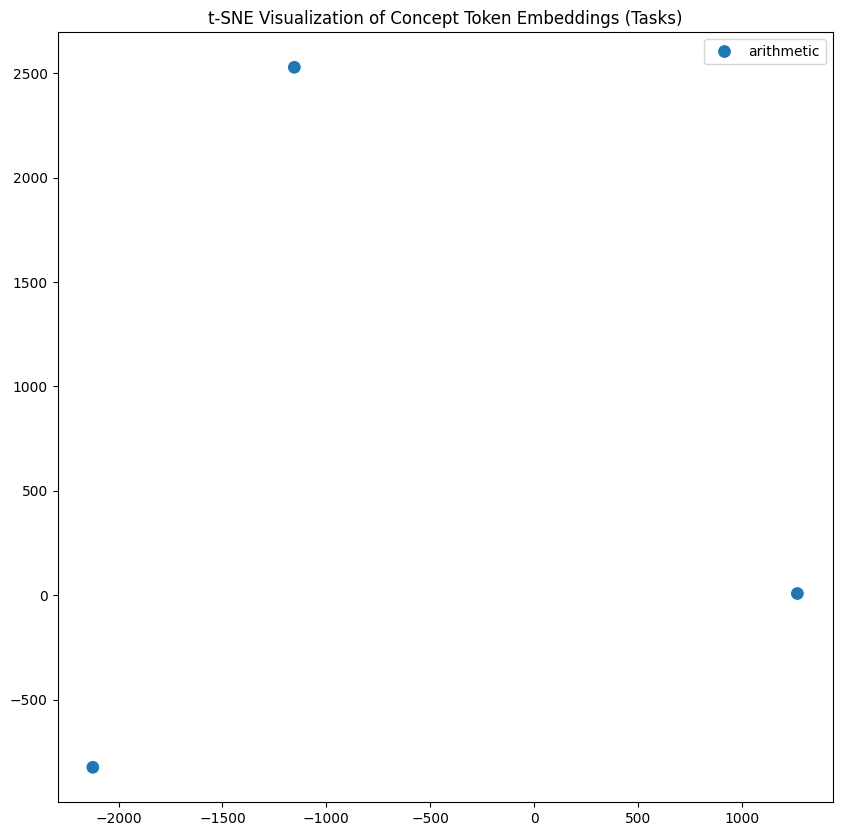

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Visualizing token contributions...


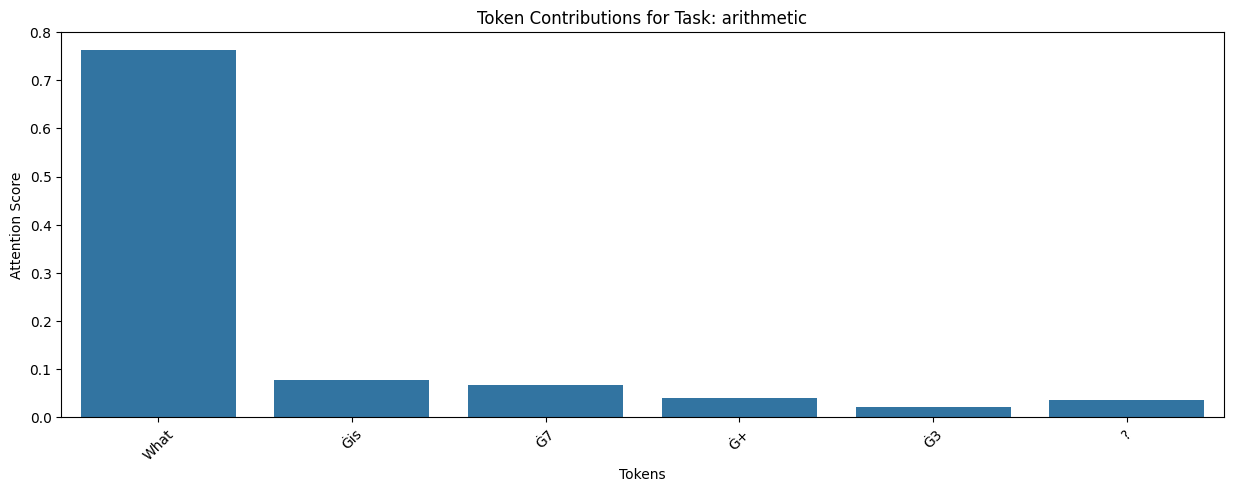

Analyzing demonstration relevance...
Selected Demonstrations: [{'input': 'The dog is barking.', 'output': 'Negative', 'task': 'text_classification'}, {'input': '5 + 2 =', 'output': '7', 'task': 'arithmetic'}]


[{'input': 'The dog is barking.',
  'output': 'Negative',
  'task': 'text_classification'},
 {'input': '5 + 2 =', 'output': '7', 'task': 'arithmetic'}]

In [4]:
# Define Configuration
config = ModelConfig(model_name="gpt2", n_prefix_tokens=5, learning_rate=1e-4)
meta_icl = MetaICL(config)

# Train the Model
tasks = ["arithmetic", "text_classification"]
train_data = [
    {"input": "2 + 2 =", "output": "4", "task": "arithmetic"},
    {"input": "The cat sat on the mat.", "output": "Positive", "task": "text_classification"}
]
meta_icl.train(train_data, tasks)

# Explain a Task
input_text = "What is 7 + 3?"
candidates = [
    {"input": "5 + 2 =", "output": "7", "task": "arithmetic"},
    {"input": "The dog is barking.", "output": "Negative", "task": "text_classification"}
]
meta_icl.explain(input_text, candidates, task="arithmetic", k=2)


In [2]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 43.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 66.3 MB/s eta 0:00:00a 0:00:01
